crypto factor model using deep neural nets
features: open, high, low, close, count, volume, rolling volatility, volume moving average, stddev of the close
predicts: close for time t + 1 with the features for t

In [1]:
#imports
from coins import Coin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential, load_model
from keras import layers
from keras.callbacks import EarlyStopping
from keras import optimizer_v2 as opt

In [2]:
#get data
coin = Coin('XXBTZUSD', interval='1440')
window = 10
nan = [None for _ in range(window)]
coin.tdata['percent_return'] = (coin.data.close-coin.data.close.shift(1))/coin.data.close.shift(1)
sma_volume = nan + [np.mean(coin.data.volume[i:i+window]) for i in range(len(coin.data.volume)-window)]
rolling_stddev = nan + [np.std(coin.data.close[i:i+window]) for i in range(len(coin.data.close)-window)]
rolling_volatility = nan + [None] + [np.std(coin.logrs[i:i+window]) for i in range(len(coin.logrs)-window)]
macd = nan + [np.mean(coin.data.close[i:i+window]) - np.mean(coin.data.close[i:i+int(window/2)]) for i in range(len(coin.data.close)-window)]
data = pd.concat([coin.tdata.drop(['time'],axis=1), pd.DataFrame({'sma_volume':sma_volume, 'rolling_stddev':rolling_stddev, 'rolling_volatility':rolling_volatility, 'macd':macd})], axis=1)
features = data.iloc[window+1:-1,:].reset_index(drop=True)
features

,open,high,low,close,vwap,volume,count,percent_return,sma_volume,rolling_stddev,rolling_volatility,macd
0,9186.4,9199.0,9061.3,9133.9,9147.0,2685.851906,8211,-0.005401,4146.689206,206.413266,0.019681,-155.56
1,9135.0,9300.3,9094.2,9234.5,9213.0,3526.761413,11919,0.011014,4202.501351,210.278594,0.019568,-153.31
2,9233.9,9269.2,8935.6,9086.0,9110.0,4547.458649,13765,-0.016081,4353.757510,210.466629,0.019864,-131.45
3,9086.0,9123.1,9041.4,9058.0,9093.5,1652.163389,7239,-0.003082,4284.722031,159.360955,0.013895,-53.85
4,9058.1,9194.8,9044.9,9138.5,9109.9,1524.403161,6148,0.008887,4087.119644,82.854489,0.013927,-8.56
...,...,...,...,...,...,...,...,...,...,...,...,...
703,30431.3,30658.9,29255.0,29676.4,29742.1,2472.705420,18044,-0.024669,3424.601825,1027.250977,0.033621,722.10
704,29676.4,29954.5,29450.1,29850.0,29693.4,783.344337,10432,0.005850,3391.255167,1026.130081,0.034306,762.84
705,29850.8,30162.4,29514.0,29907.6,29846.8,963.561140,11190,0.001930,3186.462696,1018.205193,0.034317,357.53
706,29907.6,31725.6,29881.9,31356.3,31263.4,3447.462926,21505,0.048439,2786.503982,986.853686,0.034065,-89.20


In [3]:
#preprocessing
labels = coin.tdata.close[window+2:].reset_index(drop=True)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=.2)
ct = ColumnTransformer([('only numeric', StandardScaler(), features.columns)], remainder='passthrough')
features_train = ct.fit_transform(features_train)
features_test = ct.fit_transform(features_test)

In [4]:
#model creation
def return_model():
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(features.shape[1],)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.05))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.05))
    model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dropout(.1))
    model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Dense(32, activation='relu'))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, name='Output'))
    model.compile(loss='mse', optimizer=opt.adam.Adam(learning_rate=0.00001), metrics=['mape','mae'])
    model.summary()
    return model
model = return_model()
    

2022-06-07 22:02:42.639368: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               6656      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [5]:
#training
es = EarlyStopping(monitor='val_loss', mode='min', patience=100)
history = model.fit(features_train, labels_train, epochs=5000, batch_size=15, validation_split=.175, verbose=0, callbacks=[es])

30719.154


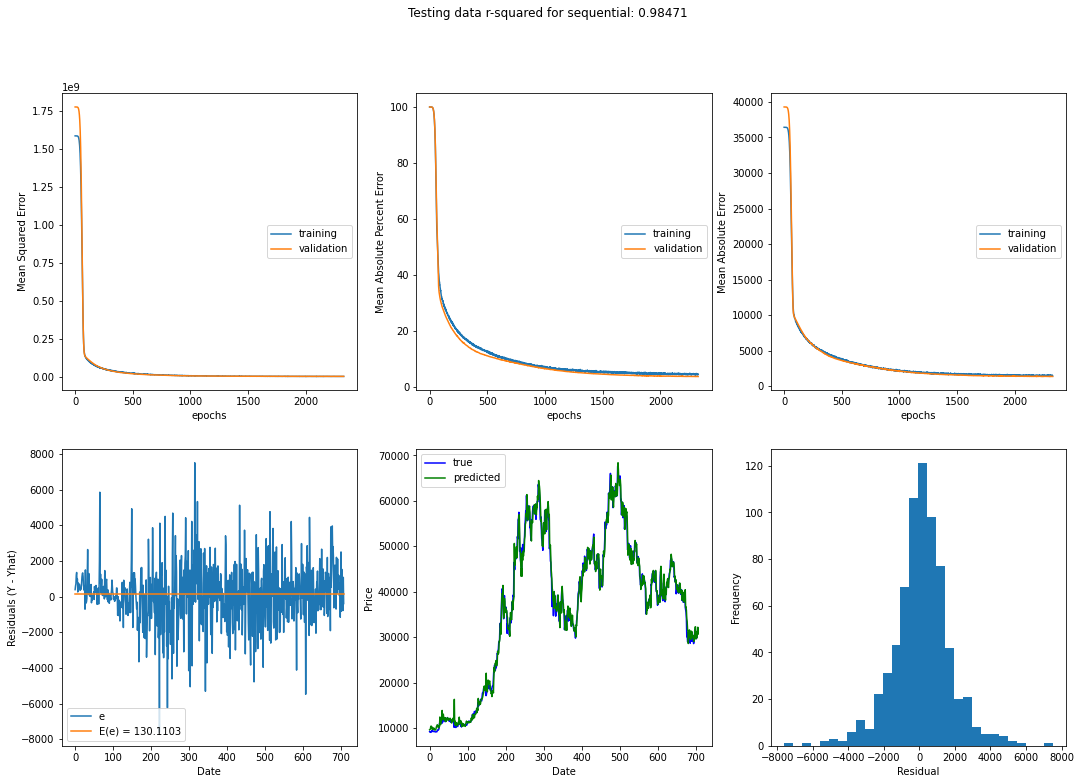

In [6]:
#show metrics for current model
fig = plt.figure('Evaluation', figsize=(18,12))
test_prediction = model.predict(features_test)
ftr = ct.fit_transform(features)
dates = coin.data.time[window+2:].reset_index(drop=True)
prediction = [p[0] for p in model.predict(ftr)]
residuals = [pred-true for true, pred in zip(labels, prediction)]
# percent_divergence = [100 * (pred-true)/true for true, pred in zip(labels, prediction)]
r2 = r2_score(test_prediction, labels_test)
fig.suptitle(f'Testing data r-squared for {model.name}: {r2:.5f}')

ax1 = fig.add_subplot(2,3,1)
ax1.plot(history.history['loss'], label='training')
ax1.plot(history.history['val_loss'], label='validation')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Mean Squared Error')
ax1.legend(loc='center right')

ax2 = fig.add_subplot(2,3,2)
ax2.plot(history.history['mape'], label='training')
ax2.plot(history.history['val_mape'], label='validation')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Mean Absolute Percent Error')
ax2.legend(loc='center right')

ax3 = fig.add_subplot(2,3,3)
ax3.plot(history.history['mae'], label='training')
ax3.plot(history.history['val_mae'], label='validation')
ax3.set_xlabel('epochs')
ax3.set_ylabel('Mean Absolute Error')
ax3.legend(loc='center right')

ax4 = fig.add_subplot(2,3,4)
ax4.plot(range(len(dates)), residuals, label='e')
ax4.plot([np.mean(residuals) for _ in range(len(dates))], label=f'E(e) = {np.mean(residuals):.4f}')
ax4.set_xlabel('Date')
ax4.set_ylabel('Residuals (Y - Yhat)')
ax4.legend(loc='lower left')

ax5 = fig.add_subplot(2,3,5)
ax5.plot(range(len(dates)), labels, label='true', color='blue')
ax5.plot(prediction, label='predicted', color='green')
ax5.set_xlabel('Date')
ax5.set_ylabel('Price')
ax5.legend(loc='upper left')

ax6 = fig.add_subplot(2,3,6)
ax6.hist(residuals, 30)
ax6.set_xlabel('Residual')
ax6.set_ylabel('Frequency')

comp = [[true,f'{pred:.2f}',f'{pred-true:.2f}',f'{(pred-true)/true:.2%}'] for true, pred in zip(labels, prediction)]
comp = [['true','pred','pred-true','pred-true%']] + comp
print(prediction[-1])

Current r-squared: 0.98471 | Loaded r-squared: 0.99116


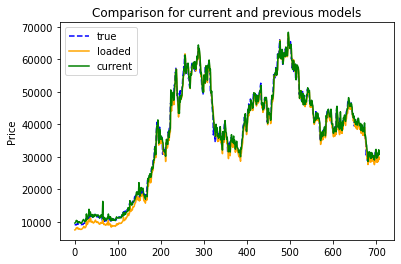

In [7]:
#compare metrics for current model vs loaded model
loaded = load_model('saves/XXBTZUSD_f12_r9802')
loaded_test_prediction = loaded.predict(features_test)
loaded_prediction = [p[0] for p in loaded.predict(ct.fit_transform(features))]
loaded_r2 = r2_score(loaded_test_prediction, labels_test)
print(f'Current r-squared: {r2:.5f} | Loaded r-squared: {loaded_r2:.5f}')
plt.plot(range(len(labels)), labels, label='true', color='blue', linestyle='--')
plt.plot(loaded_prediction, label='loaded', color='orange')
plt.plot(prediction, label='current', color='green')
plt.title('Comparison for current and previous models')
plt.legend(loc='upper left')
plt.ylabel('Price')
plt.show()

In [8]:
#save model
model.save(f'saves/{coin.pair}_f{features.shape[1]}_r{int(r2*10000)}')
# loaded.save(f'saves/{coin.pair}_f{features.shape[1]}_r{int(loaded_r2*10000)}')

2022-06-07 22:10:13.621944: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saves/XXBTZUSD_f12_r9847/assets
